# Mining frequent itemsets from the *Abalone* dataset

First, let's import some packages. In particular, we will need `numpy` and `pandas` for processing the data, as well as `pyplot` for making plots.

In [156]:
%matplotlib inline
import numpy
import pandas
import datetime
import matplotlib.pyplot as plt

In addition, we will use the Python implementation of a simplified version of the *Eclat/LCM* frequent itemset mining algorithm by C. Borgelt (https://borgelt.net/eclat.html).

In [157]:
with open("pyfim.py") as fp:
    exec(fp.read())
# from pyfim import *  # LOCALLY
# import urllib.request  # REMOTELY
# a = urllib.request.urlopen("https://members.loria.fr/EGalbrun/UEF_LPD/assignment/pyfim.py")
# exec(a.read())

## Loading and preparing the data

[Abalone](https://archive.ics.uci.edu/ml/datasets/Abalone) is one of the popular datasets from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

The dataset contains physical measurements of abalones, i.e. marine gastropod molluscs (see https://en.wikipedia.org/wiki/Abalone).

In particular, from the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names) we can find the list of attributes:

Name | Data Type | Meas. | Description | 
---- | -----| ---- | ----------- |
Sex	 | nominal |   | M, F, and I (infant) |
Length | continuous | mm | Longest shell measurement |
Diameter | continuous | mm | perpendicular to length
Height | continuous | mm | with meat in shell |
Whole weight | continuous | grams | whole abalone |
Shucked weight | continuous | grams | weight of meat |
Viscera weight | continuous | grams | gut weight (after bleeding) |
Shell weight | continuous | grams | after being dried |
Rings | integer |  | +1.5 gives the age in years |

Next, we read the data in and display an outline.

In [158]:
cnames = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
# dtf = pandas.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', sep=",", names=cnames)# REMOTELY
dtf = pandas.read_csv('abalone.data', sep=",", names=cnames) # LOCALLY
dtf

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


The dataset consists of nine attributes, one is categorical and the rest are numerical.

Frequent itemset mining operates on transactional data. 

So, we need to prepare the data in a suitable way, using discretization and binarization to obtain binary attributes, that is, discrete items.

In [159]:
dcols = [] # to store the data columns corresponding to the new attributes
item_nbs = [] # to store the number of new attributes created from each original one (for plotting)
item_lbls = [] # to store labels corresponding to the new attributes

First, for the categorical attribute *Sex* that comes with three categories, we create one new binary attribute for each category.

In [160]:
var_name, var_cats = ("Sex", ["I", "M", "F"])
cols = pandas.crosstab(dtf.index, [dtf[var_name]])  #? What is this function doing?
dcols.extend([cols[nc].values for nc in var_cats])  #? Is this adding the transformed data into the new columns/table?
dcols

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 0, ..., 1, 0, 1], dtype=int64),
 array([0, 0, 1, ..., 0, 1, 0], dtype=int64)]

We also create labels for the new attributes, to be able to recover their meaning in the analysis.

In [161]:
item_nbs.append(len(var_cats))
item_lbls.extend(["%s_%s" % (var_name, v) for v in var_cats])
item_lbls

['Sex_I', 'Sex_M', 'Sex_F']

Second, for the numerical attribute *Length*, we choose a few thresholds across its range to define bins that will each be represented as a new binary attribute. 

In [162]:
var_name, var_bounds = ("Length", [0.425, 0.51, 0.575, 0.625])  #? How were these values chosen? Was there an analysis of the data distribution to identify suitable bin values?
bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
bvs = numpy.arange(len(bins)-1)  # Return evenly spaced values within a given interval.
cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
dcols.extend([cols[nc].values for nc in bvs])
dcols[3:]  #? Why "3:" ?

[array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 1], dtype=int64)]

and the corresponding labels:

In [163]:
item_nbs.append(len(var_bounds)+1)
item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))
item_lbls[3:]

['Length_..0.425]',
 'Length_(0.425,0.51]',
 'Length_(0.51,0.575]',
 'Length_(0.575,0.625]',
 'Length_(0.625..']

And similarly for the other numerical attributes, each with a few chosen thresholds for binning...

In [164]:
for var_name, var_bounds in [ 
    ("Diameter", [0.325, 0.395, 0.45, 0.495]),
    ("Height", [0.105, 0.13, 0.15, 0.175]),
    ("WholeWeight", [0.366, 0.6445, 0.93, 1.2385]),
    ("ShuckedWeight", [0.157, 0.2745, 0.4, 0.542]),
    ("VisceraWeight", [0.0765, 0.1405, 0.201, 0.273]),
    ("ShellWeight", [0.109, 0.1895, 0.27, 0.351]),
    ("Rings", [7.0, 9.0, 10.0, 12.0])
]:
    bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
    bvs = numpy.arange(len(bins)-1)
    cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
    dcols.extend([cols[nc].values for nc in bvs])
    item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
    item_nbs.append(len(var_bounds)+1)
    item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
    item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))

Then, we put the columns together, obtaining a binary matrix...

In [165]:
bin_mat = numpy.vstack(dcols).T  # https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
bin_mat[:4]

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]],
      dtype=int64)

... and turn it into a list of transactions, i.e. sets of items, as expected by our frequent itemset mining algorithm.

In [166]:
# Frozen set is just an immutable version of a Python set object. While elements of a set can be modified at any time, elements of the frozen set remain the same after creation.
# numpy.where = Return elements chosen from x or y depending on condition.

tracts = [frozenset(numpy.where(r)[0]) for r in bin_mat]  #? Is it using numpy.where just because frozenset requires an iterable? So it goes through the matrix and for every 0, it puts 0?
tracts[:4]

[frozenset({1, 4, 9, 13, 19, 24, 29, 34, 42}),
 frozenset({1, 3, 8, 13, 18, 23, 28, 33, 38}),
 frozenset({2, 5, 10, 15, 20, 24, 30, 35, 39}),
 frozenset({1, 4, 9, 14, 19, 24, 29, 34, 40})]

## Looking at the statistics of the data

In [167]:
len(tracts)

4177

In total, we have 4177 transactions in our prepared dataset, each corresponds to one individual abalone.

Because each individual came with a value for each of the original attributes and we discretized the attributes using non-overlapping intervals covering the entire range of values, each transaction contains one item for each of the original attributes. As a results, each transactions contains 9 items, i.e. they all have the same size.

In [168]:
set(numpy.sum(bin_mat, axis=1))

{9}

Next, we make a histogram of the number of occurrences of the different items, grouped by the original attribute to which they correspond.

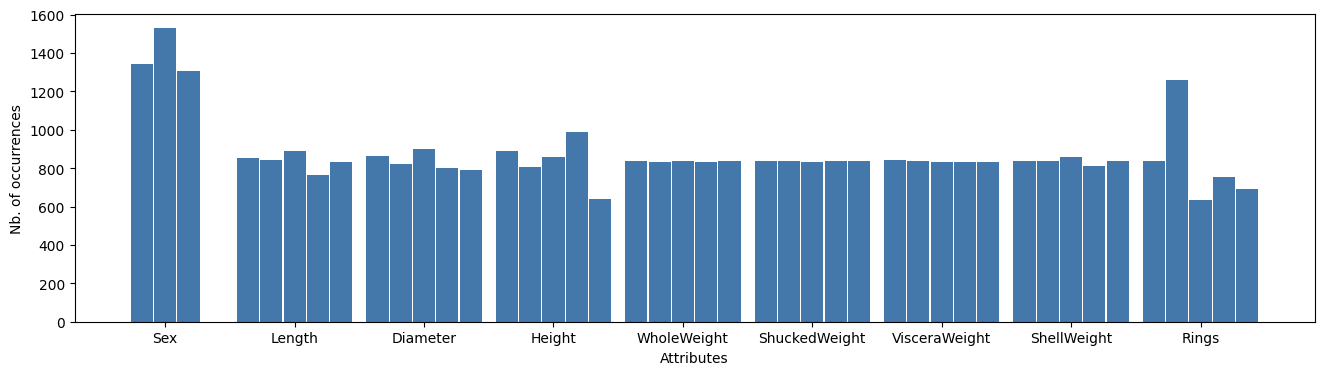

In [169]:
plt.figure(figsize=(16,4))
h = numpy.sum(bin_mat, axis=0)
bw = 0.9/numpy.max(item_nbs)
bf = 0.95
xbs = []
for ni, nb in enumerate(item_nbs):
    xbs.extend([ni+(n-0.5*(nb-1+bf))*bw for n in range(nb)])
plt.bar(xbs, h, width=bf*bw, align='edge', color=(68/255., 119/255., 170/255.))
plt.xticks(range(len(cnames)), cnames)
plt.xlabel("Attributes")
plt.ylabel("Nb. of occurrences")
plt.show()

Except for the number of rings, where the item corresponding to 7 or 8 rings is more frequent than the other items, the thresholds used to discretize the numerical attributes result in bins of approximately equal heights. As a consequence, the resulting items appear with roughly the same frequency, of about 4177/5 or 20%.

The frequencies of the three items generated from the *Sex* attribute correspond to the distribution, in the abalone population covered by the dataset, of infants, males and females, respectively. 

## Mining itemsets

Now, we are ready to run the frequent itemset mining algorithm on the transactional dataset.

First, we try with a relatively high support threshold, of 15% (0.15 x 4177 ~ 626).

In [170]:
nb_tot = len(tracts)
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=15)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 190 itemsets in 0:00:00.019000


Several dozens of frequent itemsets were mined in fractions of a second.

Let's have a look at the top ten most frequent.

In [171]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

Sex_M (1,) 1528 0.366
Sex_I (0,) 1342 0.321
Sex_F (2,) 1307 0.313
Rings_(7.0,9.0] (39,) 1257 0.301
Height_(0.15,0.175] (16,) 986 0.236
Diameter_(0.395,0.45] (10,) 902 0.216
Height_..0.105] (13,) 888 0.213
Length_(0.51,0.575] (5,) 887 0.212
Diameter_..0.325] (8,) 863 0.207
Height_(0.13,0.15] (15,) 858 0.205


Expectedly, the most frequent itemsets are singletons, i.e. they correspond to occurrences of individual physical properties. This is of limited interest, we could already see these frequencies in the histogram.

Next, we lower slightly the support threshold, to 500 occurrences.

In [172]:
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=-500)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 529 itemsets in 0:00:00.020991


More than twice as many itemsets are returned...

Lowering the support threshold again, now to 250 occurrences.

In [173]:
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=-250)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 1187 itemsets in 0:00:00.026996


More than a thousand itemsets are returned...

Now keeping the support threshold constant, but mining the closed frequent itemsets (target='c').

In [174]:
tic = datetime.datetime.now()
FI = fim(tracts, target='c', supp=-250)  # target='c' means we're targeting the closed frequent itemsets
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 1176 itemsets in 0:00:00.031000


And again, with the same support threshold, but this time mining the maximal frequent itemsets (target='m').

In [175]:
tic = datetime.datetime.now()
FI = fim(tracts, target='m', supp=-250)  # target='m' means we're targeting the maximal frequent itemsets
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 136 itemsets in 0:00:00.041001


Finally, we mine closed frequent itemsets with a support threshold of 10%, keeping only itemsets of size three or more (zmin=3).

In [176]:
tic = datetime.datetime.now()
FI = fim(tracts, target='c', supp=10, zmin=3)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 561 itemsets in 0:00:00.022018


Among these hundreds of itemsets, we look at the top ten, where we can find the most common co-occurrences of physical attributes.

In [177]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))  #? labels, itemset, abs supp, rel. supp

WholeWeight_..0.366] Length_..0.425] Diameter_..0.325] (18, 3, 8) 783 0.187
ShellWeight_..0.109] Length_..0.425] Diameter_..0.325] (33, 3, 8) 774 0.185
ShellWeight_..0.109] WholeWeight_..0.366] Diameter_..0.325] (33, 18, 8) 767 0.184
VisceraWeight_..0.0765] Length_..0.425] Diameter_..0.325] (28, 3, 8) 765 0.183
ShellWeight_..0.109] WholeWeight_..0.366] Length_..0.425] (33, 18, 3) 764 0.183
WholeWeight_..0.366] VisceraWeight_..0.0765] Length_..0.425] (18, 28, 3) 761 0.182
WholeWeight_..0.366] VisceraWeight_..0.0765] Diameter_..0.325] (18, 28, 8) 761 0.182
ShellWeight_..0.109] WholeWeight_..0.366] Length_..0.425] Diameter_..0.325] (33, 18, 3, 8) 757 0.181
WholeWeight_..0.366] VisceraWeight_..0.0765] Length_..0.425] Diameter_..0.325] (18, 28, 3, 8) 756 0.181
WholeWeight_..0.366] ShuckedWeight_..0.157] Length_..0.425] (18, 23, 3) 754 0.181


We might be interested to carry this analysis further. For instance, we might look for association rules that relate dimensions of the abalone, its age (nb. of rings) and its sex...

## Observations

Top occurences of each attribute:
- Sex: Male
- Length: 0.51-0.575
- Diameter: 0.395-0.45
- Height: 0.15-0.175
- WholeWeight: equivalent
- ShuckedWeight: equivalent
- VisceraWeight: min - 0.0765
- ShellWeight: 0.1895-0.27
- Rings: 9-10

Most common co-occurences of physical attributes (supp. thresh. of 10%, itemset size > 3):
1. WholeWeight, Length, Diameter
2. ShellWeight, Length, Diameter
3. ShellWeight, WholeWeight, Diameter
4. VisceraWeight, Length, Diameter
5. ShellWeight, WholeWeight, Length

Looking at the top 5, there seems to be an association between weight and size of the anemole. But what about the other attributes, such as sex and rings? Does the number of rings correlate to the weight and size of the anemole, or is it the sex?

### Sex and Rings

Sex is identified by labels:
0 - Infant
1 - Male
2 - Female

And rings are identfied by labels from 38 to 42 (increases number of rings as the label number increases)

In [178]:
print(f"- Sex: {item_lbls[0:3]} \n- Rings: {item_lbls[38:43]}")

- Sex: ['Sex_I', 'Sex_M', 'Sex_F'] 
- Rings: ['Rings_..7.0]', 'Rings_(7.0,9.0]', 'Rings_(9.0,10.0]', 'Rings_(10.0,12.0]', 'Rings_(12.0..']


Let's sort the top 10 itemsets to include either of those.

In [179]:
# Generate lists with labels of sex and ring attributes
sex_labels = list(range(0, 2))
ring_labels = list(range(38, 43))
both_labels = sex_labels + ring_labels
print_limit = 10
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in both_labels for attr in fi[0]):  # Only look at itemset including sex and rings
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Length_..0.425] Sex_I Diameter_..0.325] (3, 0, 8) 608 0.146
ShellWeight_..0.109] Sex_I Diameter_..0.325] (33, 0, 8) 605 0.145
ShellWeight_..0.109] Sex_I WholeWeight_..0.366] (33, 0, 18) 601 0.144
WholeWeight_..0.366] Sex_I Diameter_..0.325] (18, 0, 8) 601 0.144
WholeWeight_..0.366] Sex_I Length_..0.425] (18, 0, 3) 599 0.143
ShellWeight_..0.109] Sex_I Length_..0.425] (33, 0, 3) 598 0.143
WholeWeight_..0.366] Sex_I VisceraWeight_..0.0765] (18, 0, 28) 596 0.143
VisceraWeight_..0.0765] Sex_I Diameter_..0.325] (28, 0, 8) 592 0.142
WholeWeight_..0.366] Sex_I Length_..0.425] Diameter_..0.325] (18, 0, 3, 8) 589 0.141
ShellWeight_..0.109] Sex_I Length_..0.425] Diameter_..0.325] (33, 0, 3, 8) 588 0.141


With both labels, we see that sex infant is the most common. Restricting the results to those that contain rings gives the following:

In [180]:
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in ring_labels for attr in fi[0]):  # Only look at itemsets including rings
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Rings_..7.0] Length_..0.425] Diameter_..0.325] (38, 3, 8) 586 0.140
ShellWeight_..0.109] Rings_..7.0] Diameter_..0.325] (33, 38, 8) 581 0.139
ShellWeight_..0.109] Rings_..7.0] Length_..0.425] (33, 38, 3) 577 0.138
ShellWeight_..0.109] Rings_..7.0] WholeWeight_..0.366] (33, 38, 18) 576 0.138
WholeWeight_..0.366] Rings_..7.0] Length_..0.425] (18, 38, 3) 575 0.138
WholeWeight_..0.366] Rings_..7.0] Diameter_..0.325] (18, 38, 8) 575 0.138
ShellWeight_..0.109] Rings_..7.0] Height_..0.105] (33, 38, 13) 569 0.136
ShellWeight_..0.109] Rings_..7.0] Length_..0.425] Diameter_..0.325] (33, 38, 3, 8) 569 0.136
ShellWeight_..0.109] Rings_..7.0] WholeWeight_..0.366] Diameter_..0.325] (33, 38, 18, 8) 568 0.136
Rings_..7.0] VisceraWeight_..0.0765] Length_..0.425] (38, 28, 3) 568 0.136


From the resulting itemsets, it can be seen that only abalones of sex infant and with less than 7 rings appear. This means that younger abalones are frequently more similar in physical attributes than older ones. Or, in other words, as abalones grow older, they gain differing characteristics, and thus the itemsets related to those are not so frequent.

What about adult abalones?

In [181]:
# Lower the support threshold
FI = fim(tracts, target='c', supp=-100, zmin=3)
print("Found %d itemsets in %s" % (len(FI), elps))

sex_labels = list(range(1, 2))
ring_labels = list(range(38, 43))
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in sex_labels for attr in fi[0]) and any(attr in ring_labels for attr in fi[0]):
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 2889 itemsets in 0:00:00.022018
ShellWeight_(0.1895,0.27] Sex_M Rings_(7.0,9.0] (35, 1, 39) 159 0.038
Rings_(10.0,12.0] Length_(0.625.. Sex_M (41, 7, 1) 155 0.037
Rings_(10.0,12.0] ShuckedWeight_(0.542.. Sex_M (41, 27, 1) 152 0.036
Rings_(10.0,12.0] WholeWeight_(1.2385.. Sex_M (41, 22, 1) 149 0.036
Rings_(12.0.. ShellWeight_(0.351.. Sex_M (42, 37, 1) 148 0.035
Rings_(10.0,12.0] Diameter_(0.495.. Sex_M (41, 12, 1) 145 0.035
Rings_(10.0,12.0] ShellWeight_(0.351.. Sex_M (41, 37, 1) 143 0.034
Rings_(10.0,12.0] WholeWeight_(1.2385.. Sex_M ShuckedWeight_(0.542.. (41, 22, 1, 27) 142 0.034
Rings_(10.0,12.0] VisceraWeight_(0.273.. Sex_M (41, 32, 1) 142 0.034
ShuckedWeight_(0.4,0.542] Rings_(7.0,9.0] Sex_M (26, 39, 1) 141 0.034


With a low support threshold of 100 and minimum itemset size of 3, we're able to find 2889 itemsets that fit the criteria of either being male or female in sex, and containing the number of rings attributes.

The most common case is that of a male abanole with 7 to 9 rings and shell weight between 0.1895 and 0.27. As this abanole is younger than the other male abanoles in the ranking, there's an indication that the assumption of younger abanoles resembling eachother is correct. For the other cases, the most common number of rings in male abanoles is a value between 10 and 12.

# The House dataset

The `house` dataset includes votes for each of the U.S. House of Representatives Congressmen on the 16 key votes identified by the CQA. This is a relatively small dataset (435 instances). More information at https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

## Pre-processing

Let's start by reading the data and displaying an outline.

In [182]:
cnames = [
    'Class', 'Handicapped infants', 'Water project cost sharing', 'Adoption of the budget resolution',
    'Physician fee freeze', 'El Salvador aid', 'Religious groups in schools', 'Anti-satellite test ban',
    'Aid to Nicaraguan Contras', 'Mx Missile', 'Immigration', 'Synfuels Corporation cutback',
    'Education spending', 'Superfund right to sue', 'Crime', 'Duty free exports',
    'Export administration act South Africa']
dtf = pandas.read_csv('house.data', sep=",", names=cnames)
dtf

,Class,Handicapped infants,Water project cost sharing,Adoption of the budget resolution,Physician fee freeze,El Salvador aid,Religious groups in schools,Anti-satellite test ban,Aid to Nicaraguan Contras,Mx Missile,Immigration,Synfuels Corporation cutback,Education spending,Superfund right to sue,Crime,Duty free exports,Export administration act South Africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


The dataset consists of `17 attributes`, all categorical. 

The `Class` attribute consists of two options: `republican` and `democrat`. The other attributes consist of `y`, `n`, or `?`, representing the chosen vote (y = yes, n = no), or neutrality/undisclosed (`?`).

Now, we must prepare the data with binarization to obtain discrete items for Frequent Itemset Mining.

In [183]:
dcols = [] # to store the data columns corresponding to the new attributes
item_nbs = [] # to store the number of new attributes created from each original one (for plotting)
item_lbls = [] # to store labels corresponding to the new attributes

First, for the `Class` attribute, we have two categories.

In [184]:
 #! This output looks strange. Is this correct?

var_name, var_cats = ("Class", ["republican", "democrat"])
cols = pandas.crosstab(dtf.index, [dtf[var_name]])  
dcols.extend([cols[nc].values for nc in var_cats])

And for the labels:

In [185]:
item_nbs.append(len(var_cats))
item_lbls.extend(["[%s - %s]" % (var_name, v) for v in var_cats])
item_lbls

['[Class - republican]', '[Class - democrat]']

Now, for the other attributes, we have three categories: `y`, `n`, and `?`.

In [186]:
for var_name, var_cats in [
    ("Handicapped infants", ['y', 'n', '?']),
    ("Water project cost sharing", ['y', 'n', '?']),
    ("Adoption of the budget resolution", ['y', 'n', '?']),
    ("Physician fee freeze", ['y', 'n', '?']),
    ("El Salvador aid", ['y', 'n', '?']),
    ("Religious groups in schools", ['y', 'n', '?']),
    ("Anti-satellite test ban", ['y', 'n', '?']),
    ("Aid to Nicaraguan Contras", ['y', 'n', '?']),
    ("Mx Missile", ['y', 'n', '?']),
    ("Immigration", ['y', 'n', '?']),
    ("Synfuels Corporation cutback", ['y', 'n', '?']),
    ("Education spending", ['y', 'n', '?']),
    ("Superfund right to sue", ['y', 'n', '?']),
    ("Crime", ['y', 'n', '?']),
    ("Duty free exports", ['y', 'n', '?']),
    ("Export administration act South Africa", ['y', 'n', '?']),
]:
    cols = pandas.crosstab(dtf.index, [dtf[var_name]])  
    dcols.extend([cols[nc].values for nc in var_cats])
    item_nbs.append(len(var_cats))
    item_lbls.extend(["[%s - %s]" % (var_name, v) for v in var_cats])

Putting everything together, we obtain the binary matrix:

In [187]:
bin_mat = numpy.vstack(dcols).T  # https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
bin_mat[-1]

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0], dtype=int64)

Turning the binary matrix into a list of transactions (i.e., sets of items), to be used as input for the FIM algorithm:

In [188]:
tracts = [frozenset(numpy.where(r)[0]) for r in bin_mat]
tracts[-1]

frozenset({0, 3, 5, 9, 11, 14, 17, 21, 24, 27, 29, 33, 35, 38, 41, 46, 48})

## Statistics

In [189]:
len(tracts)

435

There are `435 transactions` in total. Each transaction corresponds to one individual voter.

Each transaction contains `17 items`:

In [190]:
set(numpy.sum(bin_mat, axis=1))

{17}

The histogram of the data shows more clearly the voting distribution accross categories:
- for the `Class` attribute, the first bar is `republican`, and the second one is `democrat`;
- for other attributes, the first bar is `y`, second is `n`, third is `?`.

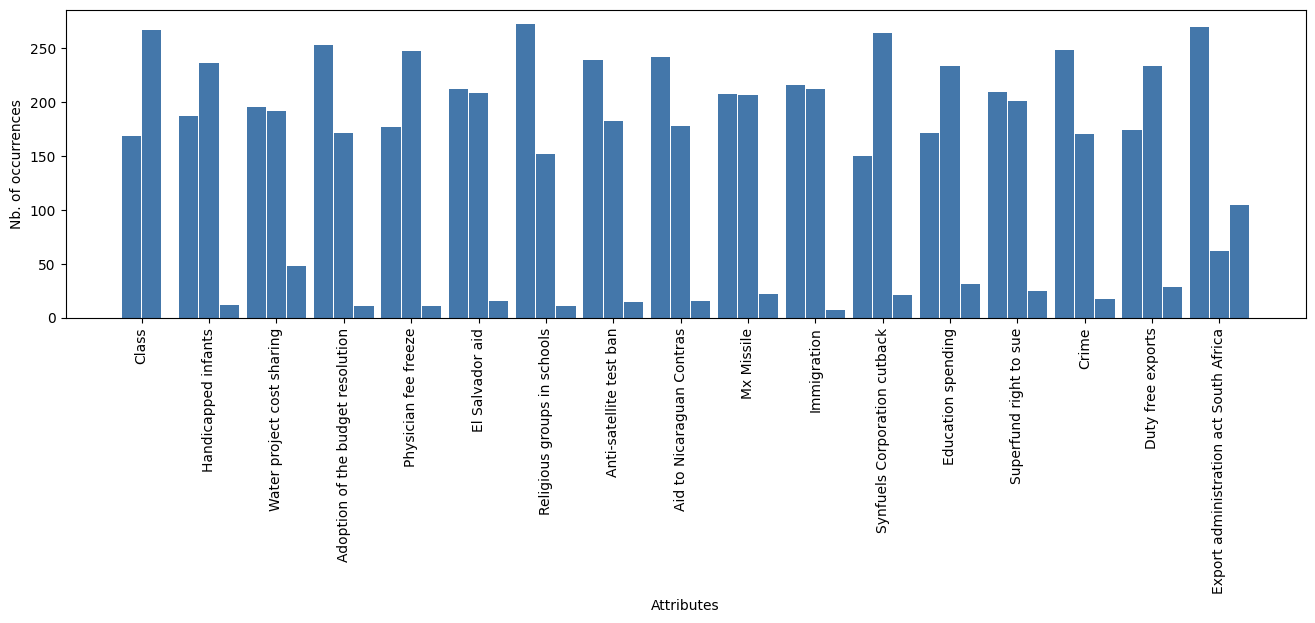

In [191]:
plt.figure(figsize=(16,4))
h = numpy.sum(bin_mat, axis=0)
bw = 0.9/numpy.max(item_nbs)
bf = 0.95
xbs = []
for ni, nb in enumerate(item_nbs):
    xbs.extend([ni+(n-0.5*(nb-1+bf))*bw for n in range(nb)])
plt.bar(xbs, h, width=bf*bw, align='edge', color=(68/255., 119/255., 170/255.))
plt.xticks(range(len(cnames)), cnames, rotation='vertical')
plt.xlabel("Attributes")
plt.ylabel("Nb. of occurrences")
plt.show()

According to the dataset information page, we have 267 democrats and 168 republicans, as is evident by the histogram. Some other noticeable points are:
- the votes with most uncertainty (`?`) are `Export administration act South Africa`, `Water project cost sharing`, and `Education spending`. Although they have the most amount of `?` votes, `Export administration...` has a majority of `yes`, `Water project...` is almost evenly divided, and `Education spending` is mostly `no`. This might indicate that `?` does not directly correlate to a consensus, or lack there of, of voting, but possibly as a desire to keep the voter opinion secret;
- the votes with an even amount of `yes` and `no` are: `Water project cost sharing`, `El Salvador aid`, `Mx Missile`, `Immigration`, and `Superfund right to sue`;
- votes with a big majority lead (>25%) on either `yes` or `no` are: `Adoption of the budget resolution` (yes), `Physician fee freeze` (no), `Religious groups in schools` (yes), `Synfuels Corporation cutback` (no), `Crime` (yes), and `Export administration act South Africa` (yes). 

As such, there is a clear difference in frequency for the items in the `house` dataset: votes with `?` are much less frequent than others (except for the `Export administration...` case), and the `yes` or `no` categories vary with the specific vote.


## Mining

Running the FIM algorithm with a support threshold of 15% (0.15*435 ~ 65), we obtain the following:

In [192]:
nb_tot = len(tracts)
FI = fim(tracts, target='s', supp=15)
print("Found %d itemsets in %s" % (len(FI), elps))

Found 31080 itemsets in 0:00:00.022018


The top 10 most frequent are:

In [193]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

[Religious groups in schools - y] (17,) 272 0.625
[Export administration act South Africa - y] (47,) 269 0.618
[Class - democrat] (1,) 267 0.614
[Synfuels Corporation cutback - n] (33,) 264 0.607
[Adoption of the budget resolution - y] (8,) 253 0.582
[Crime - y] (41,) 248 0.570
[Physician fee freeze - n] (12,) 247 0.568
[Physician fee freeze - n] [Class - democrat] (12, 1) 245 0.563
[Aid to Nicaraguan Contras - y] (23,) 242 0.556
[Anti-satellite test ban - y] (20,) 239 0.549


Most are singletons. Interestingly, the itemset of `democrats` voting `no` for `Physician fee freeze` appears in the top 10.

Restricting the algorithm to itemsets of size 2 gives us the following top 10: 

In [194]:
FI = fim(tracts, target='s', supp=15, zmin=2)
print("Found %d itemsets in %s" % (len(FI), elps))

print('')  # Space between prints

for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

Found 31046 itemsets in 0:00:00.022018

[Physician fee freeze - n] [Class - democrat] (12, 1) 245 0.563
[Adoption of the budget resolution - y] [Class - democrat] (8, 1) 231 0.531
[Physician fee freeze - n] [Adoption of the budget resolution - y] [Class - democrat] (12, 8, 1) 219 0.503
[Physician fee freeze - n] [Adoption of the budget resolution - y] (12, 8) 219 0.503
[Aid to Nicaraguan Contras - y] [Class - democrat] (23, 1) 218 0.501
[Aid to Nicaraguan Contras - y] [Adoption of the budget resolution - y] (23, 8) 215 0.494
[Crime - y] [Religious groups in schools - y] (41, 17) 214 0.492
[Education spending - n] [Class - democrat] (36, 1) 213 0.490
[Aid to Nicaraguan Contras - y] [Physician fee freeze - n] (23, 12) 211 0.485
[Anti-satellite test ban - y] [Aid to Nicaraguan Contras - y] (20, 23) 210 0.483


This results shows us that, under a support threshold of 15%, the most votes were for `Physician fee freeze - n` and `Adoption of the budget resolution - y` by the `democrats`. Not only that, but the third most votes was the union of those two itemsets.

Since we have 17 attributes, let's have a look at the most frequent maximal itemsets (15% supp. threshold).

In [195]:
FI = fim(tracts, target='m', supp=15, zmin=2)
print("Found %d itemsets in %s\n" % (len(FI), elps))

i = 1
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
    i += 1

Found 1021 itemsets in 0:00:00.022018

1 [Immigration - y] [Synfuels Corporation cutback - n] [Export administration act South Africa - y] (29, 33, 47) 94 0.216
2 [Immigration - y] [Handicapped infants - n] [Export administration act South Africa - y] (29, 3, 47) 85 0.195
3 [Handicapped infants - y] [Duty free exports - n] (2, 45) 82 0.189
4 [Water project cost sharing - n] [Immigration - n] (6, 30) 80 0.184
5 [Immigration - y] [Duty free exports - n] [Export administration act South Africa - y] (29, 45, 47) 80 0.184
6 [Duty free exports - n] [Anti-satellite test ban - y] (45, 20) 79 0.182
7 [Water project cost sharing - n] [Handicapped infants - n] [Synfuels Corporation cutback - n] (6, 3, 33) 78 0.179
8 [Education spending - n] [Duty free exports - n] (36, 45) 78 0.179
9 [Adoption of the budget resolution - y] [Religious groups in schools - y] [Export administration act South Africa - y] (8, 17, 47) 78 0.179
10 [Religious groups in schools - n] [Crime - n] [Superfund right to sue - n

The resulting itemsets shows us votes that are commonly made together. The top one, for example, could indicate an association such as: if the voter is in favor of `Immigration` and `Export administration act South Africa`, then he is against `Synfuels Corporation cutback`. Or, on the second case, the voter would be against `Handicapped infants`. 

In the top 10 itemsets above, only one of them includes the `Class` attribute. We can see that this frequent itemset states that often `democrats` vote in favor of `Mx Missile`, `Anti-satellite test ban`, `Adoption of the budget resolution`, and `Aid to Nicaraguan Contras`, but against `Religious groups in schools`, `Crime`, `Superfund right to sue`, `Education spending`, `El Salvador aid`, and `Physician fee freeze`.

What if we restricted the resulting itemsets to those that contain one of the categories in the `Class` attribute? Let's see the top 10 most common itemsets of votes for `democrats`:

In [196]:
FI = fim(tracts, target='m', supp=15, zmin=2)
print("Found %d itemsets in %s\n" % (len(FI), elps))

class_labels = [1]  # democrat
print_limit = 10
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 1021 itemsets in 0:00:00.022018

1 [Religious groups in schools - n] [Crime - n] [Superfund right to sue - n] [Mx Missile - y] [Education spending - n] [Anti-satellite test ban - y] [Adoption of the budget resolution - y] [El Salvador aid - n] [Aid to Nicaraguan Contras - y] [Class - democrat] [Physician fee freeze - n] (18, 42, 39, 26, 36, 20, 8, 15, 23, 1, 12) 77 0.177
2 [El Salvador aid - n] [Immigration - y] [Adoption of the budget resolution - y] [Anti-satellite test ban - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (15, 29, 8, 20, 12, 23, 1) 77 0.177
3 [Synfuels Corporation cutback - y] [Water project cost sharing - y] [Class - democrat] (32, 5, 1) 75 0.172
4 [Synfuels Corporation cutback - y] [Religious groups in schools - y] [Class - democrat] (32, 17, 1) 75 0.172
5 [Duty free exports - y] [Superfund right to sue - n] [Mx Missile - y] [Education spending - n] [Adoption of the budget resolution - y] [Anti-satellite test ban - y] [El Sal

The top results has 11 attributes (including `Class`), showing that democrats have a tendency of voting similarly. An interesting point is that the top result shows votes against `Religious groups in schools` (support of 77), but the fourth results shows votes in favor for it (75 support). This may indicate two distinct groups inside the `democrats` group.

What about republicans?

In [197]:
FI = fim(tracts, target='m', supp=15, zmin=2)
print("Found %d itemsets in %s\n" % (len(FI), elps))

class_labels = [0]  # republican
print_limit = 10
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 1021 itemsets in 0:00:00.022018

1 [Class - republican] [Export administration act South Africa - y] [Synfuels Corporation cutback - n] [El Salvador aid - y] [Physician fee freeze - y] [Crime - y] (0, 47, 33, 14, 11, 41) 72 0.166
2 [Class - republican] [Anti-satellite test ban - n] [Handicapped infants - n] [Superfund right to sue - y] [Education spending - y] [Duty free exports - n] [Crime - y] [Adoption of the budget resolution - n] [Religious groups in schools - y] [Aid to Nicaraguan Contras - n] [El Salvador aid - y] [Mx Missile - n] [Physician fee freeze - y] (0, 21, 3, 38, 35, 45, 41, 9, 17, 24, 14, 27, 11) 72 0.166
3 [Class - republican] [Export administration act South Africa - y] [Superfund right to sue - y] [El Salvador aid - y] [Crime - y] [Physician fee freeze - y] (0, 47, 38, 14, 41, 11) 70 0.161
4 [Class - republican] [Immigration - y] [Aid to Nicaraguan Contras - n] [Crime - y] [El Salvador aid - y] [Physician fee freeze - y] (0, 29, 24, 41, 14, 11) 69 0.159
5 [Cla

The top 2 results have the same support value. Interestingly, the 2nd result contains 13 attributes (including `Class`), which indicates a stronger consensus between `republicans` in comparison with `democrats`.

Let's check for a consensus of 5 votes for both `democrats` and `republicans`, only closed frequent itemsets with a support threshold of 30%.

In [198]:
FI = fim(tracts, target='c', supp=30, zmin=6)
print("Found %d itemsets in %s\n" % (len(FI), elps))

class_labels = [0, 1]  # republican, democrat
print_limit = 10
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 43 itemsets in 0:00:00.022018

1 [El Salvador aid - n] [Adoption of the budget resolution - y] [Anti-satellite test ban - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (15, 8, 20, 12, 23, 1) 164 0.377
2 [El Salvador aid - n] [Education spending - n] [Adoption of the budget resolution - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (15, 36, 8, 12, 23, 1) 154 0.354
3 [Mx Missile - y] [El Salvador aid - n] [Adoption of the budget resolution - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (26, 15, 8, 12, 23, 1) 152 0.349
4 [El Salvador aid - n] [Education spending - n] [Anti-satellite test ban - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (15, 36, 20, 12, 23, 1) 151 0.347
5 [Mx Missile - y] [El Salvador aid - n] [Anti-satellite test ban - y] [Physician fee freeze - n] [Aid to Nicaraguan Contras - y] [Class - democrat] (26, 15, 20, 12, 23, 1) 15

Here, all results are for `democrats`, indicating more frequent consensus of votes when considering only 5 votes (size 6 itemsets).

# The Adult dataset

The `adult` dataset contains a mix of categorical and numerical attributes. The goal stated in its page, http://archive.ics.uci.edu/ml/datasets/Adult, is to predict whether a person makes over 50K a year or not.

Continuous attributes: `age`, `fnlwgt` (final weight), `education-num`, `capital-gain`, `capital-loss`, `hours-per-week`.

Categorical attributes: `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`. Furthermore, `yearly-salary` was added, as it is in the data but not specified by the database description.

Total of attributes: 15.

**Note**: the `fnlwgt` attribute might have been used by the developed classifier mentioned in the website, and as such might not be of interest to our analysis.

## Pre-processing

Let's first read and display the data and its outline.

In [225]:
cnames = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'yearly-salary'
    ]
dtf = pandas.read_csv('adult.data', sep=",", names=cnames, skipinitialspace=True)
dtf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,yearly-salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Since this dataset contains both categorical and numerical attributes, we must prepare it for the FIM algorithm.

In [226]:
dcols = [] # to store the data columns corresponding to the new attributes
item_nbs = [] # to store the number of new attributes created from each original one (for plotting)
item_lbls = [] # to store labels corresponding to the new attributes

Let's first do the categorical attributes:

In [227]:
for var_name, var_cats in [
    ("workclass", ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked']),
    ("education", ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool']),
    ("marital-status", ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse']),
    ("occupation", ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces']),
    ("relationship", ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried']),
    ("race", ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black']),
    ("sex", ['Female', 'Male']),
    ("native-country", ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']),
    ('yearly-salary', ['<=50K', '>50K'])
]:
    cols = pandas.crosstab(dtf.index, [dtf[var_name]])  
    dcols.extend([cols[nc].values for nc in var_cats])
    item_nbs.append(len(var_cats))
    item_lbls.extend(["[%s - %s]" % (var_name, v) for v in var_cats])


    if var_name == 'native-country':
        native_cols = cols

native_cols

native-country,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In the table above, `?` appears in the column names for `native-country`. This might be an error in the dataset, or a missing country name.

Now, for the numerical attributes, we bin the values. The bin intervals for each attribute are defined as `(max - min)/5`. For `capital-gain`, the bins were chosen manually to avoid errors (empty bin).

In [228]:
numerical_attrb = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for attrb in numerical_attrb:
    min_value = dtf[attrb].min()
    max_value = dtf[attrb].max()
    step = (max_value-min_value)/5
    print(f"{attrb}: min {min_value} max {max_value} step {step}")

age: min 17 max 90 step 14.6
fnlwgt: min 12285 max 1484705 step 294484.0
education-num: min 1 max 16 step 3.0
capital-gain: min 0 max 99999 step 19999.8
capital-loss: min 0 max 4356 step 871.2
hours-per-week: min 1 max 99 step 19.6


In [229]:
for var_name, var_bounds in [ 
    ("age", [31.6, 46.2, 60.8, 75.4]),
    ("fnlwgt", [306764, 601253, 895737, 1190221]),
    ("education-num", [4, 7, 10, 13]),
    ("capital-gain", [25000, 50000]), #19999.8, 39999.6, 59999.4, 79999.2
    ("capital-loss", [871.2, 1742.4, 2613.6, 3484.8]),
    ("hours-per-week", [20.6, 40.2, 59.8, 79.4]),
]:
    bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
    bvs = numpy.arange(len(bins)-1)
    cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
    dcols.extend([cols[nc].values for nc in bvs])
    item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
    item_nbs.append(len(var_bounds)+1)
    item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
    item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))

We can then obtain the binary matrix:

In [230]:
bin_mat = numpy.vstack(dcols).T  # https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
bin_mat[-1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

And turn it into a list of transactions for the FIM algorithm:

In [231]:
tracts = [frozenset(numpy.where(r)[0]) for r in bin_mat]
tracts[-1]

frozenset({2, 11, 24, 35, 45, 51, 56, 58, 100, 103, 106, 113, 116, 119, 125})

## Statistics

In [232]:
len(tracts)

32561

There are `32561 transactions` in total. Each transaction corresponds to one person.

Each transaction contains between `12` and `15 items`:

In [233]:
set(numpy.sum(bin_mat, axis=1))  #? Why does it have 4 elements?

{12, 13, 14, 15}

The histogram of the data shows the distribution accross categories for each person. The differences in amount inside of each attribute are evident:
- for the `age` attribute, the amount of younger people is much higher than older people (up to 31.6 years). A different binning could equalize the different bins, e.g. more bins in-between 18-30 years old;
- in the `workclass` attribute, `Federal-Gov` is the most common category;
- `Married-civ-spouse` is overwhelmingly higher in amount than other categories in the `marital-status` attribute.  

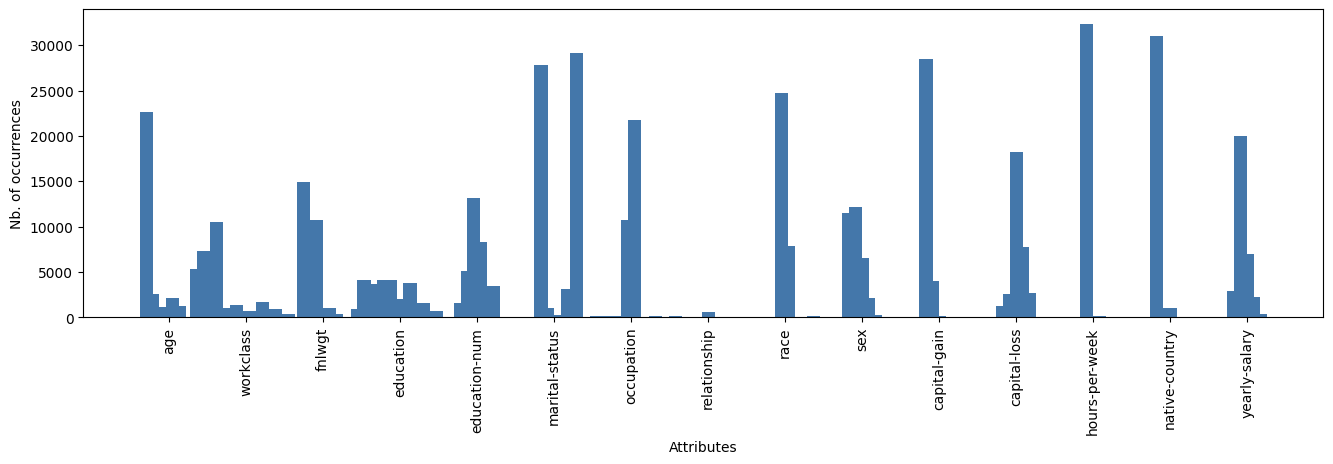

In [234]:
plt.figure(figsize=(16,4))
h = numpy.sum(bin_mat, axis=0)
bw = 3.5/numpy.max(item_nbs)
bf = 2
xbs = []
for ni, nb in enumerate(item_nbs):
    xbs.extend([ni+(n-0.5*(nb-1+bf))*bw for n in range(nb)])
plt.bar(xbs, h, width=bf*bw, align='edge', color=(68/255., 119/255., 170/255.))
plt.xticks(range(len(cnames)), cnames, rotation='vertical')
plt.xlabel("Attributes")
plt.ylabel("Nb. of occurrences")
plt.show()

## Mining

Running the FIM algorithm with a support threshold of 15% (0.15*435 ~ 65), we obtain the following:

In [235]:
nb_tot = len(tracts)
FI = fim(tracts, target='s', supp=15)
print("Found %d itemsets in %s" % (len(FI), elps))

Found 3998 itemsets in 0:00:00.022018


The top 10 most frequent are:

In [236]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

capital-gain_..25000] (116,) 32346 0.993
capital-loss_..871.2] (119,) 31070 0.954
capital-loss_..871.2] capital-gain_..25000] (119, 116) 30855 0.948
[native-country - United-States] (58,) 29170 0.896
[native-country - United-States] capital-gain_..25000] (58, 116) 28977 0.890
fnlwgt_..306764] (106,) 28444 0.874
fnlwgt_..306764] capital-gain_..25000] (106, 116) 28258 0.868
[race - White] (51,) 27816 0.854
[native-country - United-States] capital-loss_..871.2] (58, 119) 27816 0.854
[race - White] capital-gain_..25000] (51, 116) 27625 0.848


The most frequent singleton is `capital-gain_..25000`, meaning that the most common characteristic for all people is their low income. An itemset with `native-country - United-States` also appears alongside the low income, showing that most low-income people are from this country (for this dataset). We also notice that most people in the dataset are `race - White`. 

Restricting the algorithm to itemsets of size 2 gives us the following top 10: 

In [237]:
FI = fim(tracts, target='s', supp=15, zmin=2)
print("Found %d itemsets in %s" % (len(FI), elps))

print('')  # Space between prints

for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

Found 3973 itemsets in 0:00:00.022018

capital-loss_..871.2] capital-gain_..25000] (119, 116) 30855 0.948
[native-country - United-States] capital-gain_..25000] (58, 116) 28977 0.890
fnlwgt_..306764] capital-gain_..25000] (106, 116) 28258 0.868
[native-country - United-States] capital-loss_..871.2] (58, 119) 27816 0.854
[race - White] capital-gain_..25000] (51, 116) 27625 0.848
[native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (58, 119, 116) 27623 0.848
fnlwgt_..306764] capital-loss_..871.2] (106, 119) 27129 0.833
fnlwgt_..306764] capital-loss_..871.2] capital-gain_..25000] (106, 119, 116) 26943 0.827
[race - White] capital-loss_..871.2] (51, 119) 26492 0.814
[race - White] capital-loss_..871.2] capital-gain_..25000] (51, 119, 116) 26301 0.808


The most frequent itemset of size 2 is a combination of `capital-loss_..871.2` with `capital-gain_..25000`. The meaning of capital loss was not clarified in the dataset page, but it is assumed that this combination might mean an association that people of low income also possess capital loss (perhaps debt?). 

Since we have 15 attributes, let's have a look at the most frequent maximal itemsets (15% supp. threshold).

In [238]:
FI = fim(tracts, target='m', supp=15, zmin=2)
print("Found %d itemsets in %s\n" % (len(FI), elps))

i = 1
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
    i += 1

Found 186 itemsets in 0:00:00.022018

1 [sex - Male] [workclass - Private] [yearly-salary - <=50K] fnlwgt_..306764] [race - White] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (57, 0, 99, 106, 51, 58, 119, 116) 7018 0.216
2 education-num_(7,10] [sex - Male] [yearly-salary - <=50K] [race - White] fnlwgt_..306764] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (113, 57, 99, 51, 106, 58, 119, 116) 6379 0.196
3 [sex - Female] [race - White] [yearly-salary - <=50K] fnlwgt_..306764] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (56, 51, 99, 106, 58, 119, 116) 6090 0.187
4 hours-per-week_(20.6,40.2] [sex - Male] [yearly-salary - <=50K] [race - White] fnlwgt_..306764] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (125, 57, 99, 51, 106, 58, 119, 116) 6034 0.185
5 [education - HS-grad] [yearly-salary - <=50K] [race - White] fnlwgt_..306764] [native-country - United-States] 

The most common set of attributes a person has is a `white American male working privately with an yearly salary lower than 50K and capital gain lower than 25K, but also with capital loss lower than 871`. This maximal itemset has support count of `7018`, consisting `21.6%` of the maximal itemsets (for threshold 15%).

In the third position, we have a `white female American with same capital gain and loss as the male`, on a support count of `6090` (`18.7%` of the maximal itemsets).

What if we restrict the itemsets to include `yearly-salary - >50K` and check the profile of a person that receives over 50K a year? Reducing support threshold to 1%, targeting maximal itemsets, and setting the minimum itemset size to 5, we get the following top 10 itemsets:

In [263]:
FI = fim(tracts, target='m', supp=1, zmin=5)
print("Found %d itemsets in %s\n" % (len(FI), elps))

class_labels = [100]  # education - Masters
print_limit = 10
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 7791 itemsets in 0:00:00.022018

1 hours-per-week_(40.2,59.8] [yearly-salary - >50K] age_(31.6,46.2] [workclass - Private] [relationship - Husband] capital-loss_..871.2] fnlwgt_..306764] [native-country - United-States] [race - White] capital-gain_..25000] [marital-status - Married-civ-spouse] [sex - Male] (126, 100, 102, 0, 47, 119, 106, 58, 51, 116, 24, 57) 619 0.019
2 [yearly-salary - >50K] education-num_(7,10] age_(31.6,46.2] [workclass - Private] [relationship - Husband] fnlwgt_..306764] capital-loss_..871.2] [race - White] [native-country - United-States] capital-gain_..25000] [sex - Male] [marital-status - Married-civ-spouse] (100, 113, 102, 0, 47, 106, 119, 51, 58, 116, 57, 24) 562 0.017
3 [yearly-salary - >50K] hours-per-week_(20.6,40.2] age_(31.6,46.2] [workclass - Private] [relationship - Husband] [race - White] fnlwgt_..306764] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] [sex - Male] [marital-status - Married-civ-spouse] (100, 125, 102

The top 2 itemsets are very similar: white American married male. For the top itemset, we see that people are overworked, with a value between `40.2` and `59.8` hours per week, aged between `31.6` and `46.2`.

The third most frequent itemset is different from the previous two in the sense that these people work a value between `20.6` and `40.2` hours per week. This may indicate that it is not necessary to overwork yourself with many hours a week to get a decent salary of 50K or more a year, although there seems to be an association with ages between `31.6` and `46.2`.